# [IAPR 2020:][iapr2020] Lab 2 ‒  Object description

**Authors:** Sven Borden, Sorya Jullien, Artur Jesslen
**Due date:** 24.04.2020

[iapr2020]: https://github.com/LTS5/iapr-2020

## Extract relevant data
We first need to extract the `lab-02-data.tar.gz` archive.
To this end, we use the [tarfile] module from the Python standard library.

[tarfile]: https://docs.python.org/3.6/library/tarfile.html

In [162]:
import tarfile
import os

import cv2
import numpy as np
import matplotlib.pyplot as plt

data_base_path = os.path.join(os.pardir, 'data')
data_folder = 'lab-02-data'
tar_path = os.path.join(data_base_path, data_folder + '.tar.gz')
with tarfile.open(tar_path, mode='r:gz') as tar:
    tar.extractall(path=data_base_path)

## Part 1
In the `lab-02-data/part1` folder, you will find 28x28 grey-scale pictures of handwritten "0" and "1".
These digits have been extracted from MNIST dataset (http://yann.lecun.com/exdb/mnist/).

Your goal is to extract, from each of those images, a 2-dimensional feature vector (i.e. 2 features) and to plot them all on a 2D graph.
If you have chosen good features, the vectors of the "0"'s should nicely cluster in one part of the plane and those of the "1"'s in another.

Please try first the Fourier Descriptors.
You can make several attempts: e.g. with and without invariance to rotation, translation, scaling, etc.
You can also for instance rotate the images and assess the invariance in rotation.

**Note:** for the Fourier descriptors, the u_k signal has to be constructed by following the contour point after point.
Some pre-processing (image binarization, possibly some Mathematical Morphology) might be useful.

Then feel free to try other features, the more you try, the better it will be (for you).

### 1.1 Data visualization

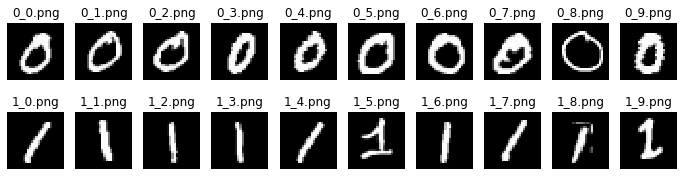

In [311]:
import skimage.io
import matplotlib.pyplot as plt
%matplotlib inline

# Load images
data_base_path = os.path.join(os.pardir, 'data')
data_folder = 'lab-02-data'

#  Load zeros
zeros_path = os.path.join(data_base_path, data_folder, 'part1', '0')
zeros_names = [nm for nm in os.listdir(zeros_path) if '.png' in nm]  # make sure to only load .png
zeros_names.sort()  # sort file names
ic = skimage.io.imread_collection([os.path.join(zeros_path, nm) for nm in zeros_names])

zeros_im = skimage.io.concatenate_images(ic)
zeros_thresholded_tmp = [cv2.threshold(img, 2, 1, cv2.THRESH_BINARY) for img in zeros_im]
zeros_thresholded = [threshold for _, threshold in zeros_thresholded_tmp]

#  Load ones
ones_path = os.path.join(data_base_path, data_folder, 'part1', '1')
ones_names = [nm for nm in os.listdir(ones_path) if '.png' in nm]  # make sure to only load .png
ones_names.sort()  # sort file names
ic = skimage.io.imread_collection(([os.path.join(ones_path, nm) for nm in ones_names]))

ones_im = skimage.io.concatenate_images(ic)
ones_thresholded_tmp = [cv2.threshold(img, 2, 1, cv2.THRESH_BINARY) for img in ones_im]
ones_thresholded = [threshold for _, threshold in ones_thresholded_tmp]

# Plot images
fig, axes = plt.subplots(2, len(zeros_im), figsize=(12, 3))
for ax, im, nm in zip(axes[0], zeros_im, zeros_names):
    ax.imshow(im, cmap='gray')
    ax.axis('off')
    ax.set_title(nm)
for ax, im, nm in zip(axes[1], ones_im, ones_names):
    ax.imshow(im, cmap='gray')
    ax.axis('off')
    ax.set_title(nm)

### 1.2 Fourier descriptors

#### Find descriptors 

In [197]:
MIN_CONTOUR_POINT = 20

In [198]:
def find_contour(img):
    """ Finds and returns the contour of the image"""
    contour = []
    contour, hierarchy = cv2.findContours(img.copy(), mode = cv2.RETR_TREE, method = cv2.CHAIN_APPROX_NONE)
    contour_array = contour[0][:, 0, :]
    if len(contour_array) < MIN_CONTOUR_POINT :
        contour_array = contour[1][:, 0, :]
    contour_complex = np.empty(contour_array.shape[:-1], dtype=complex)
    contour_complex.real = contour_array[:, 0]
    contour_complex.imag = contour_array[:, 1]
    return contour_complex

In [199]:
def find_descriptor(contour):
    """ Finds and returns the Fourier-Descriptor from the image contour"""
    return np.fft.fft(contour)

In [201]:
zero_contours = []
one_contours = []

zero_descriptors = []
one_descriptors = []

for zero_img, one_img in zip(zeros_im, ones_im):
    contour0 = find_contour(zero_img)
    zero_contours.append(contour0)
    descriptor0 = find_descriptor(contour0)
    zero_descriptors.append(descriptor0)
    
    contour1 = find_contour(one_img)
    one_contours.append(contour1)
    descriptor1 = find_descriptor(contour1)
    one_descriptors.append(descriptor1)


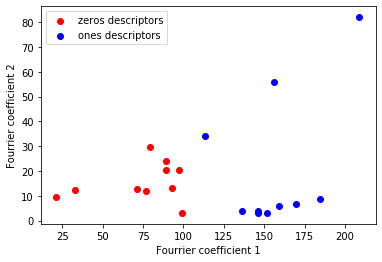

In [226]:
nb_coeff = 2
zeros_coeff = []
ones_coeff = []

for zero_descriptor, one_descriptor in zip(zero_descriptors, one_descriptors):
    zeros_coeff.append(np.absolute(zero_descriptor[1:nb_coeff+1]))
    ones_coeff.append(np.absolute(one_descriptor[1:nb_coeff+1]))

plt.scatter(np.asarray(zeros_coeff)[:,0], np.asarray(zeros_coeff)[:,1], color='red', label='zeros descriptors')
plt.scatter(np.asarray(ones_coeff)[:,0], np.asarray(ones_coeff)[:,1], color='blue', label='ones descriptors')   
plt.xlabel("Fourrier coefficient 1")
plt.ylabel("Fourrier coefficient 2")
plt.legend()
plt.show()

### 1.3 Additional method(s)


#### Freeman/Chain Code 

In [208]:
raise NotImplementedError

NotImplementedError: 

### Distance map

In [322]:
def create_distance_map(img):
    """Create distance map from binary image"""
    
    if np.unique(img).shape[0] > 2:
        raise NameError('Binary image expected.')
        
    # Initialization 
    out = np.zeros(img.shape, dtype=np.int64)
    out[img == 0] = 2**62 #infinity
    
    # Direct passage
    for i in range(1, out.shape[0]-1):
        for j in range(1, out.shape[1]-1):
            out[i, j] = np.array([out[i-1, j-1] + 4, out[i-1, j] + 3, out[i-1, j+1] + 4, out[i, j-1] + 3, out[i, j]]).min()
    
    # Inverse passage 
    for i in range(out.shape[0]-2, 0, -1):
        for j in range(out.shape[1]-2, 0, -1):
            out[i, j] = np.array([out[i, j+1] + 3, out[i+1, j-1] + 4, out[i+1, j] + 3, out[i+1, j+1] + 4, out[i, j]]).min()
    
    #!!!!!!! HERE !!!!!!!!
    border = out == 2**62 
    out[border] = 0
    out[border] = out.max()
    return out

In [327]:
def compute_dist(img, dist_map):
    """Compute distance between a binary image and another image using its distance map"""
    if np.unique(img).shape[0] > 2:
        raise NameError('Binary image expected.')
    if img.shape != dist_map.shape:
        raise NameError('Images must be of the same size.')
        
    dist = 0
    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
            if img[i,j] != 0:
                dist += dist_map[i,j] 
    return dist

## !!! If you have a better idea for the border, feel free to change !!!

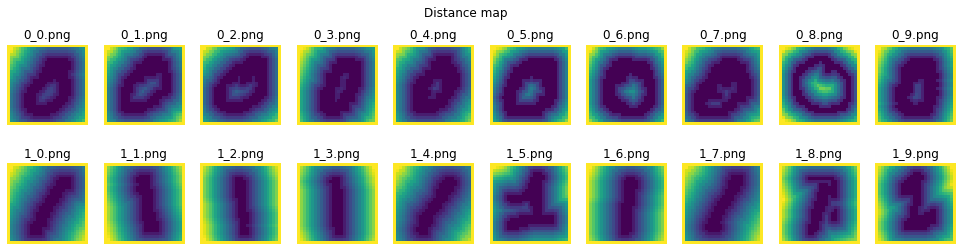

In [328]:
zeros_distance_map = [create_distance_map(img) for img in zeros_thresholded]
ones_distance_map = [create_distance_map(img) for img in ones_thresholded]

fig, axes = plt.subplots(2, len(zeros_distance_map), figsize=(17, 4))
fig.suptitle("Distance map")
for ax, im, nm in zip(axes[0], zeros_distance_map, zeros_names):
    ax.imshow(im)
    ax.axis('off')
    ax.set_title(nm)
for ax, im, nm in zip(axes[1], ones_distance_map, ones_names):
    ax.imshow(im)
    ax.axis('off')
    ax.set_title(nm)


In [341]:
zero_dist_map = zeros_distance_map[0]
one_dist_map = ones_distance_map[0]

print("Calculating distance for each zero image and associating to its nearest class:")
for i in range(1, len(zeros_distance_map)):
    dist_to_zero = compute_dist(zeros_thresholded[i], zero_dist_map)
    dist_to_one = compute_dist(zeros_thresholded[i], one_dist_map)
    print('Image {}: Its contour is closer to the contour of image of type {}'.format(zeros_names[i], 0 if dist_to_zero < dist_to_one else 1))
    print('-------------> Distance to 0: {}, distance to 1: {}'.format(dist_to_zero, dist_to_one))

print("\nCalculating distance for each zero image and associating to its nearest class:")
for i in range(1, len(zeros_distance_map)):
    dist_to_zero = compute_dist(ones_thresholded[i], zero_dist_map)
    dist_to_one = compute_dist(ones_thresholded[i], one_dist_map)
    print('Image {}: Its contour is closer to the contour of image of type {}'.format(ones_names[i], 0 if dist_to_zero < dist_to_one else 1))
    print('-------------> Distance to 0: {}, distance to 1: {}'.format(dist_to_zero, dist_to_one))


Calculating distance for each zero image and associating to its nearest class:
Image 0_1.png: Its contour is closer to the contour of image of type 0
-------------> Distance to 0: 134, distance to 1: 1063
Image 0_2.png: Its contour is closer to the contour of image of type 0
-------------> Distance to 0: 179, distance to 1: 1220
Image 0_3.png: Its contour is closer to the contour of image of type 0
-------------> Distance to 0: 141, distance to 1: 716
Image 0_4.png: Its contour is closer to the contour of image of type 0
-------------> Distance to 0: 161, distance to 1: 909
Image 0_5.png: Its contour is closer to the contour of image of type 0
-------------> Distance to 0: 307, distance to 1: 1790
Image 0_6.png: Its contour is closer to the contour of image of type 0
-------------> Distance to 0: 461, distance to 1: 1974
Image 0_7.png: Its contour is closer to the contour of image of type 0
-------------> Distance to 0: 306, distance to 1: 1582
Image 0_8.png: Its contour is closer to t

#### Region based descriptor ?

Don't know if it is worth it implementing region based descriptors 

## Part 2
The `lab-02-data/part2` folder contains grey-scale pictures of handwritten "2" and "3".
Extract the same feature (typically 2 Fourier descriptors) as in part 1 also on these images and plot them on the same graph as the features of the "0" and "1".
Is it possible to discriminate all these 4 digits with a 2-dimensional feature vector?

### 2.1 Data visualization

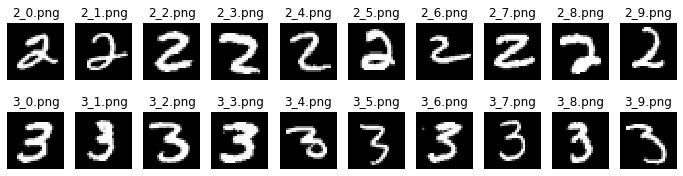

In [310]:
#  Load zeros
twos_path = os.path.join(data_base_path, data_folder, 'part2', '2')
twos_names = [nm for nm in os.listdir(twos_path) if '.png' in nm]  # make sure to only load .png
twos_names.sort()  # sort file names
ic = skimage.io.imread_collection([os.path.join(twos_path, nm) for nm in twos_names])

twos_im = skimage.io.concatenate_images(ic)
twos_thresholded_tmp = [cv2.threshold(img, 2, 1, cv2.THRESH_BINARY) for img in twos_im]
twos_thresholded = [threshold for _, threshold in twos_thresholded_tmp]

#  Load ones
threes_path = os.path.join(data_base_path, data_folder, 'part2', '3')
threes_names = [nm for nm in os.listdir(threes_path) if '.png' in nm]  # make sure to only load .png
threes_names.sort()  # sort file names
ic = skimage.io.imread_collection(([os.path.join(threes_path, nm) for nm in threes_names]))

threes_im = skimage.io.concatenate_images(ic)
threes_thresholded_tmp = [cv2.threshold(img, 2, 1, cv2.THRESH_BINARY) for img in threes_im]
threes_thresholded = [threshold for _, threshold in threes_thresholded_tmp]

# Plot images
fig, axes = plt.subplots(2, len(twos_im), figsize=(12, 3))
for ax, im, nm in zip(axes[0], twos_im, twos_names):
    ax.imshow(im, cmap='gray')
    ax.axis('off')
    ax.set_title(nm)
for ax, im, nm in zip(axes[1], threes_im, threes_names):
    ax.imshow(im, cmap='gray')
    ax.axis('off')
    ax.set_title(nm)

In [227]:
zero_contours = []
one_contours = []
two_contours = []
three_contours = []

zero_descriptors = []
one_descriptors = []
two_descriptors = []
three_descriptors = []

for zero_img, one_img, two_img, three_img in zip(zeros_im, ones_im, twos_im, threes_im):
    contour0 = find_contour(zero_img)
    zero_contours.append(contour0)
    descriptor0 = find_descriptor(contour0)
    zero_descriptors.append(descriptor0)
    
    contour1 = find_contour(one_img)
    one_contours.append(contour1)
    descriptor1 = find_descriptor(contour1)
    one_descriptors.append(descriptor1)
    
    contour2 = find_contour(two_img)
    two_contours.append(contour2)
    descriptor2 = find_descriptor(contour2)
    two_descriptors.append(descriptor2)
    
    contour3 = find_contour(three_img)
    three_contours.append(contour3)
    descriptor3 = find_descriptor(contour3)
    three_descriptors.append(descriptor3)

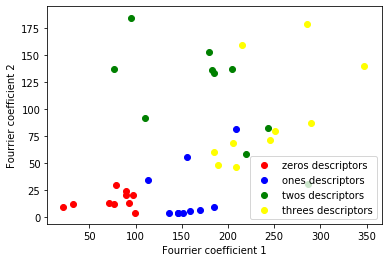

In [228]:
nb_coeff = 2
zeros_coeff = []
ones_coeff = []
twos_coeff = []
threes_coeff = []

for zero_descriptor, one_descriptor, two_descriptor, three_descriptor \
    in zip(zero_descriptors, one_descriptors, two_descriptors, three_descriptors):
    zeros_coeff.append(np.absolute(zero_descriptor[1:nb_coeff+1]))
    ones_coeff.append(np.absolute(one_descriptor[1:nb_coeff+1]))
    twos_coeff.append(np.absolute(two_descriptor[1:nb_coeff+1]))
    threes_coeff.append(np.absolute(three_descriptor[1:nb_coeff+1]))

plt.scatter(np.asarray(zeros_coeff)[:,0], np.asarray(zeros_coeff)[:,1], color='red', label='zeros descriptors')
plt.scatter(np.asarray(ones_coeff)[:,0], np.asarray(ones_coeff)[:,1], color='blue', label='ones descriptors') 
plt.scatter(np.asarray(twos_coeff)[:,0], np.asarray(twos_coeff)[:,1], color='green', label='twos descriptors')
plt.scatter(np.asarray(threes_coeff)[:,0], np.asarray(threes_coeff)[:,1], color='yellow', label='threes descriptors') 
plt.xlabel("Fourrier coefficient 1")
plt.ylabel("Fourrier coefficient 2")
plt.legend()
plt.show()

**Blablabla** as we can see on peu pas vraiment différencier, we need more dimension maybe 

### 2.2 Additional method(s) and conclusion
Add your implementations and discussions here